### 데이터 확인

In [1]:
# 준비

# !apt install fonts-nanum                  # 글꼴 설치. 설치 완료 후 런타임 재시작

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
matplotlib.font_manager._rebuild()     # json 파일에 업데이트 해주기
plt.rc('font', family='NanumGothic')    # 폰트 적용 (or  plt.rcParams['font.family'] = 'NanumGothic'  )
matplotlib.rcParams['axes.unicode_minus'] = False    # 마이너스 기호 표시 추가

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#데이터 불러오기

columns = ['체크일자', '데이터타입', '패널 NID', '메시지 NID', '업체 메시지 NID', '결제방법', '사용일시', '카드승인타입', '카드사명', '결제금액',
           '결제금액2', '카드메시지', '카드메시지2', '사용가능 여부',  '브랜드 NID', '브랜드명', '할부개월수', '업체 분류 브랜드', '주소', '위도',
           '경도', '간편결제여부', '페이먼트 종류', '페이먼트 종류_매칭용', '간편결제 가맹점명', '간편결제 가맹점명', '간편결제 사용내역', '간편결제 문자 아이디', '체크카드계좌 문자 아이디', '체크카드계좌 가맹점명',
          '문자타입', '서비스타입', '등록일자']

df = pd.read_csv('/content/drive/MyDrive/2021-07-01.csv')
# df = pd.read_csv('/content/drive/MyDrive/2021-08-01.csv')
df.columns = columns


# 사용할 데이터만 선정
df2 = df[['결제금액', '카드메시지2', '브랜드명']]
df2 # 2421104 rows × 4 columns

,결제금액,카드메시지2,브랜드명
0,15000,이미숙6월캡,미분류
1,3000,GS25중곡덕산,GS25
2,200000,경주페이,미분류
3,32880,하이웨이마트송탄지*,하이웨이마트
4,12000,월드약국,약국(종합)
...,...,...,...
2421099,3500,상주농협하나로,농협하나로마트
2421100,54000,이니시스-정,미분류
2421101,40000,잉크벨양구점,미분류
2421102,1000000,MAENWILAI,미분류


In [5]:
# 컬럼 정보 확인
df2.info()
print()

# 기존 방법으로 브랜드명 분류 조회, DF화 확인
df2_brand_count = df2['브랜드명'].value_counts().rename_axis('unique_values').reset_index(name='counts')
# df2_brand_count # 2500 rows × 2 columns : 미분류 포함 2500개 분류 : 미분는 1252380개


# 현재 데이터 전체 기준, 금액 순 정렬 + 인덱스 재설정 (데이터 분포 확인 목적)
df_test = df2.sort_values(by='결제금액', ascending=False).reset_index(drop=True)
# df_test # 2421104 rows × 3 columns

# 미분류 데이터 개수
print('미분류 데이터 개수 :',len(df_test[df_test['브랜드명'] == '미분류']))
print()

# 미분류이면서 결제 금액 천 원 이상인 데이터만 고르기
df_non_clf = df_test[(df_test['브랜드명'] == '미분류') & (df_test['결제금액'] >= 1000)].reset_index(drop=True)      # 1181541 rows × 3 columns
df_non_clf2 = df_test[(df_test['브랜드명'] == '미분류') & (df_test['결제금액'] < 1000)].reset_index(drop=True)      # 70839 rows × 3 columns


# 카드메시지2에서 NaN인 값 지우기
idx = df_non_clf[df_non_clf['카드메시지2'].isnull()].index
df_non_clf.drop(idx, inplace=True)

# 천 원 이상 / 미만 데이터 크기 확인
print('천 원 이상 / 미만 데이터 크기 확인')
print(df_non_clf.shape, df_non_clf2.shape) # (1181540, 3) (70839, 3)
print()

# 미분류 전체에서 천 원 이상이 차지하는 크기 확인
print('"미분류+천 원 이상" 데이터 비율')
print(round(len(df_non_clf) / len(df_test[(df_test['브랜드명'] == '미분류')]) * 100, 2),'%') # 94.34

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2421104 entries, 0 to 2421103
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   결제금액    int64 
 1   카드메시지2  object
 2   브랜드명    object
dtypes: int64(1), object(2)
memory usage: 55.4+ MB

미분류 데이터 개수 : 1252380

천 원 이상 / 미만 데이터 크기 확인
(1181540, 3) (70839, 3)

"미분류+천 원 이상" 데이터 비율
94.34 %


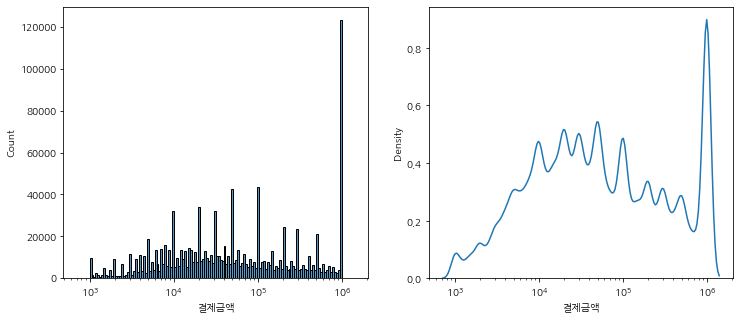

In [6]:
# 그래프로 분포 확인

import seaborn as sns
import matplotlib.pyplot as plt


# sns.distplot(df_test['결제금액']);
# sns.distplot(df_non_clf['결제금액']);

f, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
# 히스토그램
sns.histplot(df_non_clf['결제금액'], log_scale=True, ax=axes[0]);

# 커널 밀도 그래프
sns.kdeplot(df_non_clf['결제금액'], log_scale=True, ax=axes[1]);

In [7]:
# 데이터 정리 = 약 25초 소요

df_non_clf['카드메시지2'] = df_non_clf['카드메시지2'].apply(str)

# '주식회사', '주식회', '유한회사', '유한'제거, '지점'을 '점'으로 통일
df_non_clf['카드메시지2'] = df_non_clf['카드메시지2'].str.replace('주식회사', '')
df_non_clf['카드메시지2'] = df_non_clf['카드메시지2'].str.replace('주식회', '')
df_non_clf['카드메시지2'] = df_non_clf['카드메시지2'].str.replace('주식', '')
df_non_clf['카드메시지2'] = df_non_clf['카드메시지2'].str.replace('\(주\)', '')

df_non_clf['카드메시지2'] = df_non_clf['카드메시지2'].str.replace('유한회사', '')
df_non_clf['카드메시지2'] = df_non_clf['카드메시지2'].str.replace('유한회', '')
df_non_clf['카드메시지2'] = df_non_clf['카드메시지2'].str.replace('\(유\)', '')

df_non_clf['카드메시지2'] = df_non_clf['카드메시지2'].str.replace('지점', '점')
df_non_clf['카드메시지2'] = df_non_clf['카드메시지2'].str.replace('일반', '')

df_non_clf['카드메시지2'] = df_non_clf['카드메시지2'].str.replace('\(재\)', '')
df_non_clf['카드메시지2'] = df_non_clf['카드메시지2'].str.replace('\(사\)', '')



# 영어 → 한글로 변경
def en_translate(text):
  en_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
  en_to_kor = {'A' : '에이', 'B' : '비', 'C' : '씨', 'D' : '디', 'E' : '이', 'F' : '에프', 'G' : '지', 'H' : '에이치', 'I': '아이', 'J' : '제이', 'K' : '케이', 'L' : '엘', 'M' : '엠',
                   'N' : '엔', 'O' : '오', 'P' : '피', 'Q' : '큐', 'R' : '알', 'S' : '에스', 'T' : '티', 'U' : '유', 'V' : '브이', 'W': '더블유', 'X' : '엑스', 'Y' : '와이', 'Z' : '지'}

  word = list(text)
  for num, x in enumerate(word):
    if x.upper() in en_list:
      word[num] = en_to_kor[x.upper()]

  return "".join(word)

df_non_clf['카드메시지_수정'] = df_non_clf['카드메시지2'].apply(en_translate)



# 많이 사용하는 영어 단어는 한글 발음으로 변경 (확인하고 추가하기)
df_non_clf['카드메시지_수정'] = df_non_clf['카드메시지_수정'].str.replace('피에이와이', '페이')



# 기타 문자, 띄어쓰기, 숫자 제거
import re
def re_sub(text):
  return re.sub(r"[*0-9_()-/#@%$+&:;. ]", "", text)

df_non_clf['카드메시지_수정'] = df_non_clf['카드메시지_수정'].apply(re_sub)



# '미분류' 칼럼 제거
df_non_clf.drop(columns='브랜드명', inplace=True)

df_non_clf                   # 1181540 rows × 4 columns

,결제금액,카드메시지2,카드메시지_수정
0,1000500,현대리싸이클,현대리싸이클
1,1000000,대광통신 정,대광통신정
2,1000000,김현희,김현희
3,1000000,K5(4353)매입,케이매입
4,1000000,김순길,김순길
...,...,...,...
1181536,1000,3팝피씨,팝피씨
1181537,1000,김윤서,김윤서
1181538,1000,여수광양항만공,여수광양항만공
1181539,1000,SMS 06월요금,에스엠에스월요금


In [8]:
# 데이터 정리 : 3분 58초

# 미분류 데이터 중 브랜드별 개수 확인, DF화
df2_non_clf_list = df_non_clf['카드메시지_수정'].value_counts().rename_axis('카드메시지_수정').reset_index(name='횟수')

# '내용없음' 제거
idx = df2_non_clf_list[df2_non_clf_list['카드메시지_수정'] == '내용없음'].index
df2_non_clf_list.drop(idx, inplace=True)

# 빈칸 제거
idx = df2_non_clf_list[df2_non_clf_list['카드메시지_수정'] == ''].index
df2_non_clf_list.drop(idx, inplace=True)
# df2_non_clf_list              # 509317 rows × 2 columns


# 00카드 데이터 제거 (현업에서도 미사용하는 데이터)
for message in df2_non_clf_list['카드메시지_수정']:
  if message.endswith(('카드', '출금', '대금', '출통', '수수료', '요금', '선불', '후불')):
    idx = df2_non_clf_list[df2_non_clf_list['카드메시지_수정'] == message].index
    df2_non_clf_list.drop(idx, inplace=True)

df2_non_clf_list  # 506897 rows × 2 columns

,카드메시지_수정,횟수
10,현대캐피탈,2967
11,교통버스건,2942
12,임대료,2597
15,우리카드결제,2340
16,회,2262
...,...,...
508166,감리현장개설,1
508167,명땡이,1
508168,기업김현화,1
508169,양성애에이치,1


In [9]:
# 필터링할 특정 개수 선정 : 평균과 75% (분위수) 중 큰 값으로 사용

def count_std(df):
  num1 = round(df['횟수'].mean())
  num2 = round(df['횟수'].quantile(0.75))

  if num1 > num2:
    num_std = num1
  else:
    num_std = num2

  return num_std

num_std = count_std(df2_non_clf_list)
# num_std # 2

# 기준 개수 이상인 데이터 확인
test_over = df2_non_clf_list[~(df2_non_clf_list['횟수'] <= num_std)]
test_over     # 68025 rows × 2 columns

,카드메시지_수정,횟수
10,현대캐피탈,2967
11,교통버스건,2942
12,임대료,2597
15,우리카드결제,2340
16,회,2262
...,...,...
68218,장블랑,3
68219,이천가든타임스,3
68220,의마리아의료재,3
68221,커피플라워총,3


In [10]:
# 데이터 정리 = 7분 53초 소요

# 데이터 줄이기(차원 수) = 단순 입금(이름 조회), 입출금 내역, 브랜드 파악할 수 없는 데이터 제거
import re

for message in test_over['카드메시지_수정']:

  # 사람 이름 제거 → 혹시 두 단어로 된 가게라면 나중에 조건에 추가하기
  if (len(message) <= 3) and message.startswith(
                                                ('전', '박', '최', '이', '김', '정', '심', '조', '오', '강',
                                                 '장', '황', '유', '임', '권', '윤', '신', '윤', '송', '손',
                                                 '원', '홍', '한', '석', '고', '윤', '허', '곽', '변', '류',
                                                 '남', '맹', '안', '류', '함')
                                                 ):                 
    idx = test_over[test_over['카드메시지_수정'] == message].index
    test_over.drop(idx, inplace=True)

  # 단순 송금 제거 : 토스000 ...
  elif (len(message) <= 6) and message.startswith(('토스', '농협', '국민', '신한', '카뱅', '하나', '우체국', '씨티')): 
    idx = test_over[test_over['카드메시지_수정'] == message].index
    test_over.drop(idx, inplace=True)

  # 매달 사용하는 것으로 예상되는 단어 + 일반 명사
  elif message.endswith(('입출통', '요금', '임대료', '월세', '관리비', '곗돈', '자동', '회차', '계돈', '계금', '결제다', '그리고',
                         '회비', '상품권', '대금', '식대', '저축회', '알바', '취소', '카드값', '태권도', '부가세', '경조사', '수업', '납부',
                         '영어', '수학', '피아노', '공과금', '가게세', '대체', '경기', '관세', '한국', '저금', '현금', '세금', '매입',
                         '수업료', '환불', '집세', '경비', '모임', '밥값', '점심', '생수', '입니다', '노란', '웨더', '아버지', '아빠',
                         '수도세', '매점', '뱅킹', '퇴직연', '원두막', '서울', '떠나요', '남편', '과일', '누구나', '산책', '집밥', '한끼',
                         '다락방', '월분', '결제', '저축', '우동집', '세차', '좋은', '사랑방', '우리나라', '활동비', '이체', '엄마',
                         '문화인', '번호', '용돈', '이체', '좋은날', '세계로', '서서', '코코', '폐기물', '시급', '월급', '시댁', '생신',
                         '오케이', '낼날', '가족', '값', '대행', '대보험', '한식', '쉼표', '통합', '편의점', '제주', '일본', '얼음', '더하기',
                         '학원비', '계비', '기숙사비', '여비', '원비', '수선비', '차비', '경조비', '차비', '회식비', '수업비', '생활비','청소비',
                         '퀵비', '요양비', '레슨비', '간병비', '교복비', '식비', '식사비', '작업비', '모임비', '렌탈비', '교육비', '추진비',
                         '후비', '건명비', '콜비', '반품비', '실장비', '통관비', '우유비', '사례비', '차량비', '수리비', '가스비', '운임비',
                         '운영비', '마트비', '넷비', '과외비', '개인비', '배송비', '영업비', '전투비', '썬비', '교통비', '인건비', '시장비',
                         '렌트비', '출전비', '단련비', '판공비', '문서비', '잡비', '화물비', '교재비', '팀비', '용역비', '알바비', '용역비',
                         '대리비', '물류비', '노무비', '영어비', '문자비', '학습비', '재료비', '휴가비', '운송비', '유지비', '출장비', '여행비', 
                         '양육비', '택배비', '용달비', '사업비', '무용비', '식대비', '축구비', '자재비', '플랜비', '배달비', '통신비', '수입비',
                         '검사비', '권도비', '예비비', '마케팅비', '사입비', '회사비', '이전비', '립서비', '상조비', '카페비', '운반비', '세차비',
                         '세탁비', '이용비', '통학비', '앨범비', '현장비', '수고비', '광고비', '대행비', '차지비', '조사비', '일비', '말소비',
                         '주유비', '본가', '어머님', '소득세', '새벽', '대구', '진우', '재형', '수수료', '이자', '후원', '청약', '포터', '상환',
                         '방세', '물고기', '물방울', '보너스', '퇴직금', '테라스', '대행', '국민', '우리', '출금', '할부', '회수', '법인', '후원금',
                         '경찰청', '대여', '은행', '재산세', '범칙금')):
    idx = test_over[test_over['카드메시지_수정'] == message].index
    test_over.drop(idx, inplace=True)

  elif message.startswith('임대료'):
    idx = test_over[test_over['카드메시지_수정'] == message].index
    test_over.drop(idx, inplace=True)



# 가맹점만 확인
idx_list = [] # 가맹점으로 끝나는 목록 인덱스
name_list = [] # 가맹점 이름 제거한 가게 이름 목록

for message in test_over['카드메시지_수정']:
  if message.endswith('점'):
    if not message.endswith(('정육점', '과자점', '서점', '백화점', '전문점', '제과점', '반점', '상점', '할인점')):
      idx_list += test_over.index[test_over['카드메시지_수정'] == message].tolist()

for name in list(test_over[test_over.index.isin(idx_list)]['카드메시지_수정']):
  if name.endswith('본점'):
    name = name[:-2]
    name_list.append(name)
  else:
    name = name[:-3]
    name_list.append(name)

temp = test_over[test_over.index.isin(idx_list)]
temp.drop(columns='카드메시지_수정', inplace=True)
temp['카드메시지_수정'] = name_list
test_over[test_over.index.isin(idx_list)] = temp



# 한글자 단어 제거 + 빈칸으로 되는 데이터 제거
for message in test_over['카드메시지_수정']:
  if len(message) == 1:
    idx = test_over[test_over['카드메시지_수정'] == message].index
    test_over.drop(idx, inplace=True)

  elif len(message) == 2 and message.endswith(('카드', '커피', '마트', '카페', '부산', '북경', '해외', '부자', '김밥', '인천', '운임',
                                              '설렘', '풍년', '자유', '반찬', '화산', '매화', '채움', '과학', '은혜', '열린', '계란', '차량', '택배',
                                               '녹즙', '키친', '농민', '프로', '휴식', '텃밭', '향촌', '친정', '공감', '치킨', '그집', '행복', '참뼈',
                                               '평안', '헤어', '버킷', '라온', '여행', '판다', '두리', '통장', '마실', '토크', '홈런', '청담', '리치',
                                               '명가', '미래', '펀드', '세븐', '본사', '쉼터', '소풍', '크림', '뽀득,' '스타', '기업', '에스', '나무',
                                               '하루', '낭만', '공간', '농구', '언니', '음료','국어', '청년', '골프', '제자', '창고', '친구', '하이',
                                               '공존', '귀족', '부의', '부조', '경사', '축의')):
    idx = test_over[test_over['카드메시지_수정'] == message].index
    test_over.drop(idx, inplace=True)
  
  elif message == '':
    idx = test_over[test_over['카드메시지_수정'] == ''].index
    test_over.drop(idx, inplace=True)



# 단어별 비중 정보 추가
test_over['비율(%)']= round(test_over['횟수']/test_over['횟수'].sum(), 5) * 100


# 인덱스 초기화
test_over.reset_index(drop=True, inplace=True)


# 필터링한 결과 전체 합
print(test_over['횟수'].sum())

test_over                   # 48612 rows × 4 columns(이전 : 68239) # count sum =356344

356369


,카드메시지_수정,횟수,비율(%)
0,현대캐피탈,2967,0.833
1,교통버스건,2942,0.826
2,경기지역화폐,2199,0.617
3,교통지하철건,1978,0.555
4,착한페이,1778,0.499
...,...,...,...
48453,전북오픈이윤,3,0.001
48454,이천가든타임스,3,0.001
48455,의마리아의료재,3,0.001
48456,커피플라워총,3,0.001


In [11]:
# 위에서 사용할 데이터 범위 지정했던 것처럼 다시 반복 (편집거리 구하기 전 개수 비교할 기준 만들기)

def count_std(df):
  num1 = round(df['횟수'].mean())
  num2 = round(df['횟수'].quantile(0.75))

  if num1 > num2:
    num_std = num1
  else:
    num_std = num2

  return num_std

num_std2 = count_std(test_over)

# 비교할 데이터
test_over2 = test_over[test_over['횟수'] > num_std2] 
test_over2      # 8920 rows × 3 columns

,카드메시지_수정,횟수,비율(%)
0,현대캐피탈,2967,0.833
1,교통버스건,2942,0.826
2,경기지역화폐,2199,0.617
3,교통지하철건,1978,0.555
4,착한페이,1778,0.499
...,...,...,...
8915,피에이엔지유오큐아이엔,8,0.002
8916,분틀,8,0.002
8917,대일에,8,0.002
8918,문정숙,8,0.002


In [12]:
# 단어별 유사도 측정 (출처 : https://lovit.github.io/nlp/2018/08/28/levenshtein_hangle/)

def levenshtein(s1, s2, cost=None, debug=False):

    if len(s1) < len(s2):
        return levenshtein(s2, s1, debug=debug)

    if len(s2) == 0:
        return len(s1)

    if cost is None:
        cost = {}

    # changed
    def substitution_cost(c1, c2):
        if c1 == c2:
            return 0
        return cost.get((c1, c2), 1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            # Changed
            substitutions = previous_row[j] + substitution_cost(c1, c2)
            current_row.append(min(insertions, deletions, substitutions))

        if debug:
            print(current_row[1:])

        previous_row = current_row

    ratio = 1- round(previous_row[-1] / (len(s1) + len(s2)), 3)

    return ratio

In [13]:
# 편집 거리 계산 하여 컬럼에 반영

def cal_similarity(df):
  sim_list = []
  s1 = df['카드메시지_수정'][0]
  s1_list = list(s1) # 기준 단어 리스트화

  for value in df['카드메시지_수정']:
    s2 = value
    
    s2_list = list(s2) # 비교 단어 리스트화
    s3_list = [] # 비교 결과 담을 리스트
    
    for x in s1_list:
      for y in s2_list:
        if x == y: # 각 단어가 같은 경우
          s3_list.append(0) # 0을 추가
        else:
          continue

    if len(s3_list) <= 1:               # 겹치는 단어가 1개거나 없는 경우
      sim_list.append(0.2)           # 일괄적으로 0.2
    else:
      similarity = levenshtein(s1, s2)
      sim_list.append(similarity)

  print('비교 기준 단어(s1) : ', s1)
  # print('df.shape:', df.shape)
  df['s1과_유사_비율'] = sim_list
  
  return df


# 유사도가 0.667 이상인 데이터만 뽑고, 기존 데이터에서 삭제 (반복 작업)
def cal_similarity2(df):
  # 유사도 계산 결과에서 필터
  df_filter = df[df['s1과_유사_비율'] >= 0.667].sort_values(by=['s1과_유사_비율', '비율(%)'], ascending=[False, False])

  # 결과 인덱스
  del_list = df_filter.index.tolist()

  # 유사도 실행 결과
  # print('유사도 0.667 이상 단어 개수 : ',len(df_filter))

  # print('유사도 0.667 이상 단어:')
  # print(df_filter['카드메시지_수정'].values)

  df.drop(index=del_list, inplace=True)
  df.reset_index(drop=True, inplace=True)
  # print('유사 단어 처리 후 df.shape : :',df.shape)

  return df_filter, df




# 위 작업 실행, 데이터 처리 : 1분 47초 소요

result_list = []
for x in range(1, len(test_over2)):
  if len(result_list) <= 1000:
    print(x,'번째 cal_similarity, cal_similarity2 실행')
    test_over2 = cal_similarity(test_over2)
    result, test_over2 = cal_similarity2(test_over2)

    if len(result) == 1:
      if len(test_over2) >= 1000:
        continue
      else:
        break

    else:                                 # 1이 아닐 때
      result_list.append(result)
      print('-------남은 데이터: ',test_over2.shape[0],'-------\n')
      
  else:
    break

print()
print('-------그룹 결과-------')
print('그룹 개수 : ',len(result_list))
print('남은 데이터')
test_over2

1 번째 cal_similarity, cal_similarity2 실행
비교 기준 단어(s1) :  현대캐피탈
-------남은 데이터:  8890 -------

2 번째 cal_similarity, cal_similarity2 실행
비교 기준 단어(s1) :  교통버스건
-------남은 데이터:  8882 -------

3 번째 cal_similarity, cal_similarity2 실행
비교 기준 단어(s1) :  경기지역화폐
-------남은 데이터:  8871 -------

4 번째 cal_similarity, cal_similarity2 실행
비교 기준 단어(s1) :  착한페이
-------남은 데이터:  8835 -------

5 번째 cal_similarity, cal_similarity2 실행
비교 기준 단어(s1) :  동백전
6 번째 cal_similarity, cal_similarity2 실행
비교 기준 단어(s1) :  대구행복충전
-------남은 데이터:  8815 -------

7 번째 cal_similarity, cal_similarity2 실행
비교 기준 단어(s1) :  에치와이
-------남은 데이터:  8787 -------

8 번째 cal_similarity, cal_similarity2 실행
비교 기준 단어(s1) :  로카모빌리티
-------남은 데이터:  8764 -------

9 번째 cal_similarity, cal_similarity2 실행
비교 기준 단어(s1) :  꽃동네
-------남은 데이터:  8760 -------

10 번째 cal_similarity, cal_similarity2 실행
비교 기준 단어(s1) :  엔에이치
-------남은 데이터:  8715 -------

11 번째 cal_similarity, cal_similarity2 실행
비교 기준 단어(s1) :  효성에프엠에스
-------남은 데이터:  8692 -------

12 번째 cal_similari

,카드메시지_수정,횟수,비율(%),s1과_유사_비율
0,곰네트워,11,0.003,0.2
1,구산,11,0.003,0.2
2,오레노카츠,11,0.003,0.2
3,웅이네오돌뼈,11,0.003,0.2
4,농협더불어민주,11,0.003,0.2
...,...,...,...,...
993,대장부,8,0.002,0.2
994,백은경,8,0.002,0.2
995,서경애,8,0.002,0.2
996,단지,8,0.002,0.2


In [14]:
# 데이터 처리 : 1분 소요

# 남겨진 데이터들의 금액 확인
sum = 0
for name in test_over2['카드메시지_수정'].values:
  sum += df_non_clf[df_non_clf['카드메시지_수정'] == name]['결제금액'].sum()

round((sum / df_non_clf['결제금액'].sum()), 5)*100 # 0.41% 이니 무시해도 무방

0.393

In [15]:
# 데이터 처리 : 9분 32초 소요

import pprint
pp = pprint.PrettyPrinter(indent=2)


def cal_total_amount(li_st):
  print(f'유사도 측정 결과, 총 그룹 개수는 {len(li_st)}개 입니다.')
  name_sum_list = {}
  name_sim_list = {}

  for order in li_st:
    name_list = order['카드메시지_수정'].values
    s1 = name_list[0]
    name_sim_list[s1] = order['카드메시지_수정'].values[1:]
    
    sum = 0
    for name in name_list:
      sum += df_non_clf[df_non_clf['카드메시지_수정'] == name]['결제금액'].sum()

    name_sum_list[s1] = sum
  
  return name_sum_list, name_sim_list

name_sum_list, name_sim_list = cal_total_amount(result_list)
# print()
# pp.pprint(name_sum_list)

유사도 측정 결과, 총 그룹 개수는 914개 입니다.


In [16]:
# 최종 데이터 보여주기

# 너비 설정
pd.set_option('max_colwidth', 80)

# s1 기준 유사 단어 취합한 결과 합, 내림차순으로 정렬
sorted_result = sorted(name_sum_list.items(), key= lambda x : x[1], reverse = True)

# sorted_result 사용, df화 진행
final_result = pd.DataFrame(
                            {'s1_이름' : name_sum_list.keys(),
                             's1_유사_단어' : name_sim_list.values(),
                             },
                            index=range(len(sorted_result)))

numbers = []
for data in final_result['s1_유사_단어']:
  nums = len(data)
  numbers.append(nums)

# 칼럼 데이터 설정
final_result['유사_단어_개수'] = numbers
final_result['총금액(원)'] = name_sum_list.values()
final_result['총금액(원)/전체_금액(%)'] = round((final_result['총금액(원)'] / df_non_clf['결제금액'].sum()), 5)*100

# 표시 방법 설정
final_result['총금액(원)'] = final_result['총금액(원)'].map('{:12,d}'.format)
final_result.sort_values('총금액(원)', ascending=False, inplace=True)
final_result.reset_index(drop=True, inplace=True)

# 1억원 이상 데이터만 선정
final_result[final_result['총금액(원)/전체_금액(%)'] >= 0.1]

,s1_이름,s1_유사_단어,유사_단어_개수,총금액(원),총금액(원)/전체_금액(%)
0,현대캐피탈,"[현대캐피탈주, 신한현대캐피탈, 한국캐피탈, 산은캐피탈, 케이비캐피탈, 애큐온캐피탈, 디지비캐피탈, 한국캐피탈주, 오케이캐피탈, 현대커머...",29,"2,990,775,381",1.245
1,경기지역화폐,"[천안지역화폐, 밀양지역화폐, 경남지역상품, 오픈지역사랑, 경기관광개발, 경기두레소비, 경기고속도로, 경기마트개봉, 경기할인마트, 대구지...",10,"857,873,009",0.357
2,착한페이,"[청주페이, 경주페이, 천안페이, 강릉페이, 착한탕국, 삼성페이, 착한밥상, 착한식판, 착한식당, 착한밥집, 착한가게, 제로페이, 착한돼...",35,"584,248,129",0.243
3,케이비,"[케이비총, 케이알, 케이엘, 케이에, 아이비, 케이카, 케이원, 제이비, 케이스, 케이지, 케이헴, 케이, 케이비제이, 케이비오픈, 케...",41,"464,044,824",0.193
4,대구행복충전,"[대경교통충전, 대영가스충전소, 대명가스충전소, 대양가스충전소, 대전가스충전소, 포항사랑충전, 대공원충전소, 대구시설공단, 대구축산농협,...",18,"439,760,578",0.183
5,우리마트,"[우리마트, 우리마트, 우리마트, 우리마트, 우리마트, 우리마트총, 우리들마트, 우리마트로, 우리마트감, 우리마트만, 우리마트진, 우리마...",755,"420,756,780",0.175
6,엔에이치,"[엔에이치엔, 비에이치, 엠에이치, 디에이치, 에이치, 엔에이, 엔에이치농협, 제이에이치, 이앤에이치, 대주에이치, 에이치앤, 에이치에,...",44,"384,178,242",0.160
7,여민전,[여민락],1,"305,921,000",0.127
8,에치와이,"[에치와이총, 에이치와이, 에스와이, 에치와, 에이치케이, 에스제이, 에스에이, 에스케이, 에스지이, 에이치와이제이, 에이치앤디이, 에스...",27,"304,652,014",0.127
9,에스엠에스알림,"[에스엠아이스크림, 에스에스마트, 에스에스유통, 에스에스마트, 에스에스총, 에스케이에스케이, 씨에스씨에스마트, 에스엠서비스토탈, 에스에스...",29,"289,743,029",0.121


### 정리 과정

In [ ]:
# 결제 금액 확인 : 2421104 rows × 3 columns
df2.sort_values(by='결제금액', ascending=False)

,결제금액,카드메시지2,브랜드명
415912,238562800,국세청 서울지,국세
395667,50000000,카카오뱅 남원주,카카오-제거용
182747,47070000,계좌이동,"예금,적금(제외)"
652479,45910798,대출금상환,단기카드대출(현금서비스)
18102,43000000,S우체국적금,"예금,적금(제외)"
...,...,...,...
577384,1,김옥주,미분류
245731,1,모 금고김병준,미분류
413627,1,김지철,미분류
1382522,1,남재야,미분류


In [ ]:
# 컬럼 정보 확인
df2.info()

 #   Column  Dtype e 
# ---  ------  ----- 
#  0   결제금액    int64 
#  1   카드메시지2  object
#  2   브랜드명    object
# dtypes: int64(1), object(2)
# memory usage: 55.4+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1423735 entries, 0 to 1423734
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   결제금액    1423735 non-null  int64 
 1   카드메시지2  1423733 non-null  object
 2   브랜드명    1423735 non-null  object
dtypes: int64(1), object(2)
memory usage: 32.6+ MB


In [ ]:
# null 값 확인 : 카드메시지2에 하나 있음
df2.isnull().sum()

# null 값 확인
df2[df2['카드메시지2'].isnull()]

,결제금액,카드메시지2,브랜드명
781508,200000,NaN,미분류
1196922,5000,NaN,미분류


In [ ]:
# 미분류 처리한 데이터만 따로 받기 : 아니 왜 안되는거야???
# df_test.to_csv('test3.csv', index=False, header=True, encoding = 'utf-8', sep=',')

(1181540, 3) (70839, 3)
94.34 %


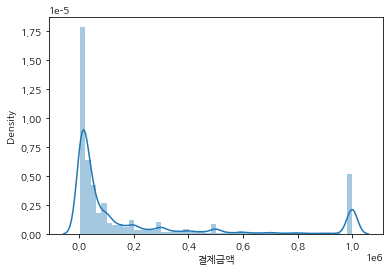

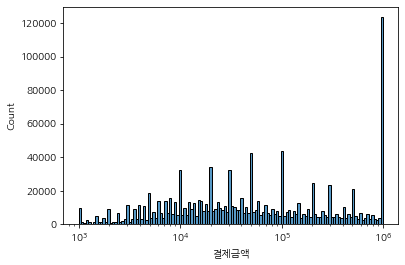

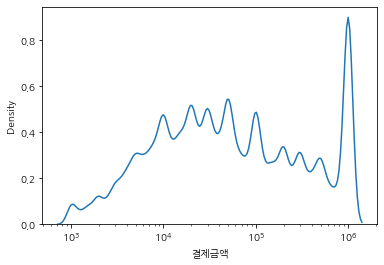

In [ ]:
# 카드메시지별 개수 확인
df2_non_clf_list.describe()

,횟수
count,508057.000000
mean,2.098028
std,13.817061
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2965.000000


In [ ]:
# 제거할 데이터 df로 확인
test = df2_non_clf_list[df2_non_clf_list['횟수'] <= num_std]
test            # 516370 ← 585273에서 대부분 차지 → 제거하기

,카드메시지_수정,횟수
68331,만복국수신내점,2
68332,쿨마트도곡총,2
68333,봉평메밀애,2
68334,다운타운상가관,2
68335,권대호,2
...,...,...
509314,최성훈오피,1
509315,종로계림닭도리탕원조보라매공원,1
509316,달서구김준,1
509317,연금보험월미영,1


In [ ]:
# 중복값인 행 합치기 작업 : 중복 카드메시지 확인 → 어차피 나중에 인덱스 일괄 확인해서 취합할 것이므로 큰 의미 없음

# dup_list = list(test_over[test_over['카드메시지_수정'].duplicated()]['카드메시지_수정'].unique())
# len(dup_list) # 618개

In [ ]:
# 위에서 불필요한 데이터 필터링한 결과 다시 counts 정보 확인
test_over[['횟수']].describe()

,횟수
count,46893.000000
mean,7.431578
std,33.612476
min,3.000000
25%,3.000000
50%,4.000000
75%,6.000000
max,2965.000000


In [ ]:
# 편집거리 결과 글자별 예시

# 글자 수 동일한 경우 (같은 종류 : 뒤가 같은 경우)
s1 = '재밌는빵집'
s2 = '신선한빵집'
print(levenshtein(s1, s2)) #.7

# 한쪽이 더 긴 경우 (s1,s2 순서 바꾸어도 결과 동일)
s1 = '좋은빵집'
s2 = '맛있고싼빵집'
print(levenshtein(s1, s2)) #.6

# 한쪽이 더 긴 경우 (앞이 같은 경우)
s1 = '현대카드'
s2 = '현대자동차'
print(levenshtein(s1, s2)) #.667

# 한쪽이 더 긴 경우 (중간이 같은 경우)
s1 = '나는현대철물'
s2 = '우리현대식당'
print(levenshtein(s1, s2)) #.667

# 글자 수 동일한 경우 (다른 종류)
s1 = '현대카드'
s2 = '착한빵집'
print(levenshtein(s1, s2)) #.5

# 한쪽이 더 긴 경우 (다른 종류)
s1 = '현대자동차'
s2 = '엄마와딸돈가스'
print(levenshtein(s1, s2)) #.417

# 글자 수 동일한 경우 (같은 종류 : 뒤가 같은 경우)
s1 = '재밌는부동산'
s2 = '친절한부동산'
print(levenshtein(s1, s2)) #.75

# 한쪽이 더 긴 경우 (s1,s2 순서 바꾸어도 결과 동일)
s1 = '좋은부동산'
s2 = '매우착한부동산'
print(levenshtein(s1, s2)) #.667

# 한쪽이 더 긴 경우 (앞이 같은 경우)
s1 = '부동산좋아'
s2 = '부동산아저씨다'
print(levenshtein(s1, s2)) #.667

# 한쪽이 더 긴 경우 (중간이 같은 경우)
s1 = '진짜부동산가요'
s2 = '우리부동산갑니다'
print(levenshtein(s1, s2)) #.667

0.7
0.6
0.667
0.667
0.5
0.41700000000000004
0.75
0.667
0.667
0.667


### 여기부터

In [ ]:
# 첫번째 cal_similarity,cal_similarity2 실행
test_over2 = cal_similarity(test_over2)
print('--------------------------------')
result1, test_over2 = cal_similarity2(test_over2)

비교 기준 단어(s1) :  삼성카드
df.shape: (7290, 3)
--------------------------------
유사도 0.667 이상 단어 개수 :  22
유사도 0.667 이상 단어:
['삼성카드' '현대카드' '씨티카드' '차이카드' '광주카드' '삼성마트' '우리카드' '삼성페이' '삼성증권' '삼성의원'
 '히든카드' '삼성슈퍼' '비씨카드' '삼성상회' '삼성안과' '삼성카드쿠폰박' '케이비카드' '스마일카드' '삼성' '의삼성의료'
 '삼성홈마트' '삼성빅마트']
유사 단어 처리 후 df.shape : : (7268, 4)


In [ ]:
# 두번째 cal_similarity,cal_similarity2 실행
test_over2 = cal_similarity(test_over2)
print('--------------------------------')
result2, test_over2 = cal_similarity2(test_over2)

비교 기준 단어(s1) :  엔에이치개인카드
df.shape: (7268, 4)
--------------------------------
유사도 0.667 이상 단어 개수 :  30
유사도 0.667 이상 단어:
['엔에이치개인카드' '엔에이치비씨개인카드' '엔에이치기업카드' '엔에이치비씨기업카드' '엔에이치비씨카드전화' '엔에이치카드인터넷'
 '엔에이치비씨인터넷' '엔에이치투자오픈' '엔에이치카드전화' '엔에이치저축은행' '엘에이치할인마트' '엔에이치체크후불'
 '엔에이치투자증권' '엔에이치캐피탈' '엔에이치엔위투' '에이치에스카페' '엔에이치농협' '엔에이치엔' '씨제이기프트카드'
 '엔에이치' '케이비국민카드' '에이치앤씨네트' '에스씨은행카드' '에이스할인마트' '에이치앤디이서' '에스에이치에드'
 '디에이치더마트' '에이치와이제이' '에이치지에너지' '에이치엔엠헤네']
유사 단어 처리 후 df.shape : : (7238, 4)


In [ ]:
result_list[1]

,카드메시지_수정,횟수,비율(%),s1과_유사_비율
0,교통버스건,2942,0.826,1.000
2,교통지하철건,1978,0.555,0.727
946,교통남산호건,31,0.009,0.727
7074,전국버스운,9,0.003,0.700
8470,교통범칙금,8,0.002,0.700
47,교통유료터널건,266,0.075,0.667
3921,위버스컴,13,0.004,0.667
7321,통학버스,8,0.002,0.667
8053,리버스팜,8,0.002,0.667


In [ ]:
# 필터 조건에 반영할 내용 찾아보기 
test_test = test_over.copy().loc[24700:25300]
test_test

# 데이터 확인
test_test['카드메시지_수정'].values

array(['두발로', '그린파크골프클럽', '농수산물마켓', '기업주에이치', '연금가수퍼', '신우식자재마트', '소담내과',
       '관악본관', '르시엘블루', '케이시원조김밥', '스카이에너지', '현진희', '시작스터디카', '동양월드마트',
       '진수상사', '국민영남에너지', '경기전기', '우리비케이에너지', '강산마트', '주공하늘마트', '호계약금',
       '케이비제이비', '또와요짬뽕', '센터시티세라젬', '수현', '메종드구르메', '카페진정', '인삼', '카페메이',
       '차이오늘집', '도씨씨오에프에프이이버블티', '메트로내과의원', '맑은샘이비인후', '제이제',
       '와이엠이십일유통안성맞', '태영수산', '안동한우', '대성석유주', '깡통만두', '대학마트', '장모님곰탕',
       '참한우', '피엘오하모니', '인디', '카페앤유파크카', '우리유지훈', '굴따세', '국제식품', '부부반찬',
       '세무법인삼성', '신한서울전자산', '커피홀릭', '도모', '해피콜', '소문난뼈해장국', '용인순대국집',
       '동일석유금', '마고미', '원정형외과', '카페아리에스', '우정회', '노벨의원', '엘하비스', '한빛안경',
       '우림분식', '매쓰빈', '튀김나라', '멘토문고', '먹자분식', '굿모닝내과', '온누리건강약', '으뜸원',
       '강원축산', '핸섬로스팅하우', '기업레이블시티', '신토불이떡볶', '고용보험', '스미일슈퍼', '하라르커피',
       '텐퍼센트커피부', '짜장면집', '씨앤', '중앙플라워', '코끼리충전소', '엠패스트', '와룡축산물판매장',
       '드림문구', '의료법인서원', '원트포항', '서민국수', '유박사곱창', '도서출판낮잠이', '문화공구',
       '가족할인마트', '원고개마트', '참마트정육', '에스케이에스케이공단엘피지충전소', '복터진집', '바니',
   

### 업체 분류 확인

In [ ]:
# 기존 업체에서 분류한 목록 확인

data_list = pd.read_excel('/content/drive/MyDrive/브랜드 종류.xlsx')
data_list

# data_list[data_list.duplicated()] # 59건 리스트 중복

,Name
0,상돈이비빔돼지
1,시나본(CINNABON)
2,다비치안경
3,투비치킨
4,월간피자
...,...
7812,펫프렌즈
7813,푸드장
7814,마이테레사
7815,셀렉온


In [ ]:
# 분류한 데이터에서 중복값 확인
data_list[data_list.duplicated()]

,Name
358,청진동해장국
580,more.TT
700,이종구낙지세상
933,인정국물떡볶이
934,인정국물떡볶이
1127,큰집아저씨
1326,우두머리
1355,우두머리
1751,청진동해장국
1777,대독장


In [ ]:
corp_list = list(data_list['Name'])
corp_list # len(corp_list) 7817

['상돈이비빔돼지',
 '시나본(CINNABON)',
 '다비치안경',
 '투비치킨',
 '월간피자',
 '속초애 명태간장조림',
 '시카고왁싱',
 '블록베이커리',
 '7번가피자',
 '도도아카데미',
 '서브웨이(SUBWAY)',
 '오빠불고기',
 '슈퍼윙스키즈카페',
 '류길상피자',
 '더족발',
 '빨간병아리',
 '시골통돼지볶음',
 '퇘장군',
 '릴라밥집',
 "몬테소리 KIDS'수",
 '한명숙피자치킨',
 '엑스칼리버',
 '더킹옴므',
 '오감캐슬',
 '동경에서먹었던규동',
 '주주블랑 (jeujeu blanc)',
 '육회본가',
 '덤인',
 '올리브영',
 '마미쿡(MOMMYCOOK)',
 '커피니(COFFEENIE)',
 "씨스페이스(C'SPACE)",
 '최용훈국어전문학원',
 '복어잡는사람들',
 '위니아대우24크린샵',
 '플랜A',
 '양평뚝배기해장국',
 '해황',
 '담락참치일잔',
 '국제통닭',
 '멘무샤',
 '호아빈',
 '구피샵',
 '일우고고싱떡볶이',
 '애플블러썸',
 '리틀팍스어학원',
 'TAPTAP(탭탭)',
 '노가리&BEER',
 "닐리스(Nilli's)",
 '폰스킹스',
 '나의 이름은 닭강정',
 "신's쭈꾸미(신스쭈꾸미)",
 '일미제면소 최가면반',
 '코레아경양식',
 '한잔하자',
 '빛가람국밥',
 '기운센갈비탕',
 '피자마루',
 '비에이블스터디카페',
 '왔쏘',
 '비타본(VITABON)',
 '닥터비어',
 '콜삼',
 '보스커피&브런치',
 'COFFEE YAS(커피야스)',
 '마마쿡(MAMA COOK)',
 '엄맛탕',
 'HONGGEDAY',
 '깐깐한쉐프들',
 '시크릿쥬쥬&또봇 프리미엄키즈카페',
 '명품병천순대',
 '수유리우동집',
 '푸드머스(KIDS)',
 '베트남 쌀국수 포냐',
 '한냥노가리',
 '행복굽는돼지집딸',
 '행복굽는돼지대장',
 '이우철삼계탕',
 '달감치킨',
 'SSOJA(쏘자)',
 '문상호 속초코다리냉면',
 '배양리두루치기',


In [ ]:
# 기존에 분류되어 있던 리스트 중 얼마나 있는지 확인

# df2_brand_count[(df2_brand_count['unique_values'].isin(corp_list))] # 1904 rows × 2 columns
df2_brand_count[~(df2_brand_count['unique_values'].isin(corp_list))] # 596 rows × 2 columns # 총 596개 추가 분류해야 함

,unique_values,counts
0,미분류,1252380
6,약국(종합),32556
8,기타주유소,27089
9,카카오페이(카카오 통합),23245
11,카카오,17664
...,...,...
2474,아이언모터스,1
2479,에듀셀파,1
2482,엠브레인,1
2486,(주)엔에스쏠,1


In [ ]:
# 데이터 전체에서 분류 리스트에 있는 것, 없는 것 확인

df2[df2['브랜드명'].isin(corp_list)] # 840748 rows × 4 columns
df2[~(df2['브랜드명'].isin(corp_list))] # 1580356 rows × 4 columns

,사용일시,결제금액,카드메시지2,브랜드명
0,16:10:11,15000,이미숙6월캡,미분류
2,15:17:43,200000,경주페이,미분류
3,13:46:53,32880,하이웨이마트송탄지*,하이웨이마트
4,18:03:59,12000,월드약국,약국(종합)
6,09:03:54,16400,후불하이패스,후불하이패스
...,...,...,...,...
2421096,20:03:08,173215,하나카드금융,미분류
2421100,13:50:19,54000,이니시스-정,미분류
2421101,16:29:59,40000,잉크벨양구점,미분류
2421102,19:13:16,1000000,MAENWILAI,미분류


### 분류률 확인

In [ ]:
# 브랜드명 별로 분류한 결과 개수 확인

df2['브랜드명'].value_counts()

# 미분류          1252380 → 1,251,135와 차이 (1,245건 차이)
# 쿠팡/쿠팡이츠        85178
# GS25           59653
# 씨유(CU)         57997
# 네이버/네이버페이      57970
#               ...   
# 아리마                1
# 에듀셀파               1
# 굽는치킨               1
# 아이언모터스             1
# 티브로드               1
# Name: 브랜드명, Length: 2500, dtype: int64

# len(df2['브랜드명'].unique()) # 2500

미분류           1252380
쿠팡/쿠팡이츠         85178
GS25            59653
씨유(CU)          57997
네이버/네이버페이       57970
               ...   
기타(제거용)             1
아리마루                1
스위트파티               1
토다이(TODAI)          1
보엔                  1
Name: 브랜드명, Length: 2500, dtype: int64

In [ ]:
# 브랜드별로 건수 구분한 결과 %로 확인

round(df2['브랜드명'].value_counts(normalize=True), 6)

# 미분류           0.517276       → 51.73% (51.68%와 미세하게 차이)
# 쿠팡/쿠팡이츠       0.035181
# GS25          0.024639
# 씨유(CU)        0.023955
# 네이버/네이버페이     0.023944
#                 ...   
# 기타(제거용)       0.000000
# 아리마루          0.000000
# 스위트파티         0.000000
# 토다이(TODAI)    0.000000
# 보엔            0.000000
# Name: 브랜드명, Length: 2500, dtype: float64

미분류           0.517276
쿠팡/쿠팡이츠       0.035181
GS25          0.024639
씨유(CU)        0.023955
네이버/네이버페이     0.023944
                ...   
기타(제거용)       0.000000
아리마루          0.000000
스위트파티         0.000000
토다이(TODAI)    0.000000
보엔            0.000000
Name: 브랜드명, Length: 2500, dtype: float64

In [ ]:
# 분류률 일치 여부 확인
df2_not = df2[df2['브랜드명'] == '미분류']
df2_not['결제금액'].sum()

# 240,274,316,894 → 240,206,945,610와 다소 차이 (67,371,284원 더 많음)

df2_yes = df2[~(df2['브랜드명'] == '미분류')]
df2_yes['결제금액'].sum()

# 113,763,305,776 → 113,824,012,206 (60,706,430원 더 적음)

240274316894

In [ ]:
# 주어진 데이터 상의 총 결제 금액
240274316894 + 113763305776 = 354037622670

# 분류률에 상의 총 결제 금액
240206945610 + 113824012206 = 354030957816 ← 여기가 좀 더 적음, 데이터 개수는 1개가 더 많은데?

354037622670

In [ ]:
# 결제 금액 % 확인

round(df2_not['결제금액'].sum() / df2['결제금액'].sum(), 4)
# 0.6787 → 67.85%와 유사

round(df2_yes['결제금액'].sum() / df2['결제금액'].sum(), 4)
# 0.3213 → 32.15%와 유사

0.6787

In [ ]:
df2_yes['결제금액'].sort_values(ascending=False)

2147088    4082000000
188190     1121756902
1652287    1000000000
1709424     999000000
1513723     900000000
              ...    
229911              1
1743181             1
1839847             1
1092268             1
214047              1
Name: 결제금액, Length: 1168724, dtype: int64

In [ ]:
# 1원짜리 결제 내역 확인
df2.loc[623166]

사용일시       11:19:45
결제금액              1
카드메시지2    (주)윈큐브마케팅
브랜드명         윈큐브마케팅
Name: 623166, dtype: object

In [ ]:
df2[df2['브랜드명'] == '윈큐브마케팅'].sort_values(by='결제금액', ascending=False)

,사용일시,결제금액,카드메시지2,브랜드명
683726,14:00:23,1000000,(주)윈큐브마케팅,윈큐브마케팅
2059127,13:54:25,967480,(주)윈큐브마케팅,윈큐브마케팅
447895,14:44:50,554240,(주)윈큐브마케팅,윈큐브마케팅
635215,18:36:36,247500,(주)윈큐브마케팅,윈큐브마케팅
572554,11:18:29,199500,(주)윈큐브마케팅,윈큐브마케팅
...,...,...,...,...
766037,17:33:06,1,(주)윈큐브마케팅,윈큐브마케팅
766759,13:52:09,1,(주)윈큐브마케팅,윈큐브마케팅
766978,11:19:35,1,(주)윈큐브마케팅,윈큐브마케팅
768703,11:22:38,1,(주)윈큐브마케팅,윈큐브마케팅


In [ ]:
# 특정 단어 포함한 결과 조회 : 치킨
df2[df2['브랜드명'].str.contains('치킨') | df2['브랜드명'].str.contains('닭')]

,사용일시,결제금액,카드메시지2,브랜드명
235,20:10:18,19900,바른치킨강릉단,바른치킨
378,18:21:48,17000,굽네치킨 청라1호점,굽네치킨
955,00:23:56,71500,불로만바베큐,불로만치킨바베큐
1417,21:46:00,29000,훈남닭발 블랙,지훈남닭발
1439,17:46:40,22000,네네치킨 구성점,네네치킨
...,...,...,...,...
2420172,20:09:30,13000,가마치 통닭 총,가마치통닭
2420600,19:40:59,12000,반월당닭강정,반월당닭강정
2421035,17:43:45,39000,교촌치킨(하,교촌치킨
2421039,23:30:43,15000,가마치통닭,가마치통닭
